<a href="https://colab.research.google.com/github/aiyufan3/AIPI-XAI-Adversarial-Patches/blob/main/aipi_assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #02 |Adversarial-Patches
### Description
This notebook demonstrates the process of creating an adversarial patch to deceive the ResNet34 model, pre-trained on ImageNet. The patch is designed to make the model misclassify a target image, which in this case is an image of a fashion item from the brand. The notebook walks through the steps, from setting up the environment and importing required libraries, to generating the adversarial patch and applying creative components for practical and visual effectiveness. Additionally, the Fast Gradient Sign Method (FGSM) is implemented as an additional adversarial attack to further explore the vulnerabilities of the model.
### Yufan Ai

#### https://colab.research.google.com/gist/aiyufan3/e9ef6b5474106b345647b015e07fc1f7/aipi-assignment-2.ipynb


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/gist/aiyufan3/e9ef6b5474106b345647b015e07fc1f7/aipi-assignment-2.ipynb)

# Environment Set Up

Create the requirements file and add necessary libraries.

In [28]:
!pip install pipreqs==0.4.11
!pipreqs --force


INFO: Successfully saved requirements file in /content/requirements.txt


##Importing Required Libraries
Importing the necessary libraries and setting up the device

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from PIL import Image
import requests
from io import BytesIO
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Pre-trained ResNet34 Model
Load the ResNet34 model pre-trained on ImageNet.

In [30]:
model = models.resnet34(weights='IMAGENET1K_V1').to(device)
model.eval()  # Set the model to evaluation mode
for param in model.parameters():
    param.requires_grad = False

# Input Image
Load the cloth brand image from Viewin and apply necessary transformations.

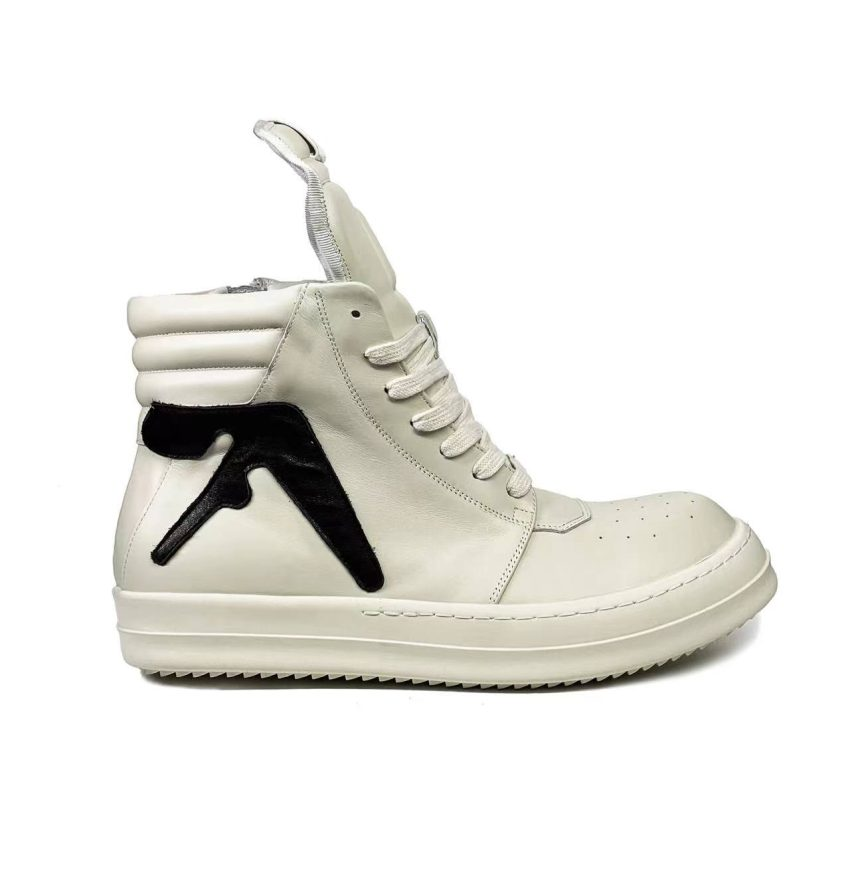

Save successfully.


In [31]:
# Load and preprocess the image
image_url = "https://viewin-online.com/wp-content/uploads/2024/05/19001716090571_.pic_-850x869.jpg" #change the url for further using
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))

# Transformations to match the ImageNet format
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet34 expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

input_image = transform(img).unsqueeze(0).to(device)
display(img)

# Convert the tensor back to a PIL format
input_image_np = input_image.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
input_image_np = np.clip(input_image_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)
input_image_pil = Image.fromarray((input_image_np * 255).astype(np.uint8))

# Ensure the 'Assignment2_OutputImage' directory exists
os.makedirs('Assignment2_OutputImage', exist_ok=True)

# Save the image in the 'Assignment2_OutputImage' directory
input_image_pil.save('Assignment2_OutputImage/input_image.jpg')

print("Save successfully.")

# Adversarial Patch

In [32]:
# Initialize the patch with random noise
patch_size = (53, 53)  # Adjust size to 53 for later design use
patch = nn.Parameter(torch.rand(3, patch_size[0], patch_size[1], device=device))

def apply_patch(image, patch, position=(10, 10)):
    patched_image = image.clone()
    patched_image[0, :, position[0]:position[0]+patch_size[0], position[1]:position[1]+patch_size[1]] = patch
    return patched_image


## Define the Adversarial Loss and Optimize the Patch
Define the loss function to target a specific class - sweatshirt from ImageNet and optimize the patch.

In [33]:
# Define target class ("swearshirt" class index is 842 from ImageNet.txt)
target_class = 842
target_label = torch.tensor([target_class], dtype=torch.long, device=device)

# Optimization settings
optimizer = optim.Adam([patch], lr=0.1)
criterion = nn.CrossEntropyLoss()

# Training loop
num_iterations = 100 #set the iterations time to 100 for patch
for i in tqdm(range(num_iterations)):
    optimizer.zero_grad()
    patched_image = apply_patch(input_image, patch, position=(90, 120))
    output = model(patched_image)
    loss = criterion(output, target_label)
    loss.backward()
    optimizer.step()
    if i % 50 == 0:
        print(f"Iteration {i}: Loss = {loss.item()}")

# After optimization, the patch is ready
final_patch = patch.detach()


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration 0: Loss = 13.034557342529297
Iteration 50: Loss = 0.026556331664323807


## Visualize

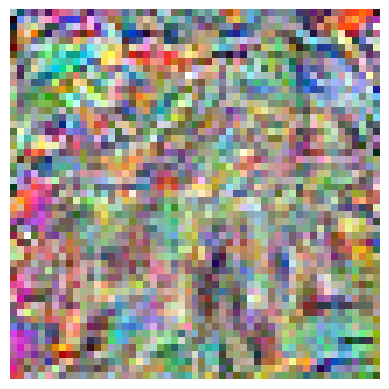

In [34]:
# Visualize the patched image and the patch
def show_image(img_tensor):
    img = img_tensor.detach().squeeze(0).cpu().numpy().transpose(1, 2, 0)
    img = np.clip(img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.show()


# Display the patch
show_image(final_patch.unsqueeze(0))


Save the adversarial_patch.jpg into folder for test training model ResNet34

In [35]:
# Save and load
torch.save(final_patch, "adversarial_patch.pt")

final_patch = torch.load("adversarial_patch.pt",weights_only=False)

# Convert
final_patch_np = final_patch.detach().cpu().numpy().transpose(1, 2, 0)
final_patch_np = np.clip(final_patch_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)
final_patch_pil = Image.fromarray((final_patch_np * 255).astype(np.uint8))

# Ensure the 'Assignment2_OutputImage' directory exists
os.makedirs('Assignment2_OutputImage', exist_ok=True)

# Save the image in the 'Assignment2_Output' directory
final_patch_pil.save('Assignment2_OutputImage/adversarial_patch.jpg')
print("Save successfully.")


Save successfully.


# Creative Component
For this part, to create a more interesting image, firstly add the adversarial patch into the original shoes input image to make it have a new design.

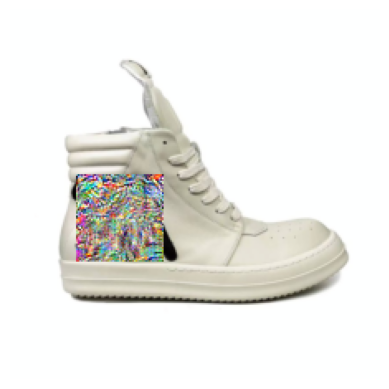

In [36]:
# Position on the shoes related to the design
patched_image = apply_patch(input_image, patch, position=(100, 40))
# Display patched image
show_image(patched_image)

Save the patch image into folder

In [37]:
# Save and load
torch.save(final_patch, "patched_image.pt")

final_patch = torch.load("patched_image.pt",weights_only=False)

# Convert
patched_image_np = patched_image.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
patched_image_np = np.clip(patched_image_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)
patched_image_pil = Image.fromarray((patched_image_np * 255).astype(np.uint8))

# Ensure the directory exists
os.makedirs('Assignment2_OutputImage', exist_ok=True)

# Save the image in the 'Assignment2_Output' directory
patched_image_pil.save('Assignment2_OutputImage/patched_image_on_shoes.jpg')
print("Save successfully.")


Save successfully.


##FGSM Implement
Use the Fast Gradient Sign Method (FGSM) as an additional adversarial attack.

In [38]:
def fgsm_attack(patched_image, epsilon, data_grad):
    # Collect gradients
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image and adding clipping
    perturbed_image = patched_image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image


Apply FGSM Attack to the Patched Image

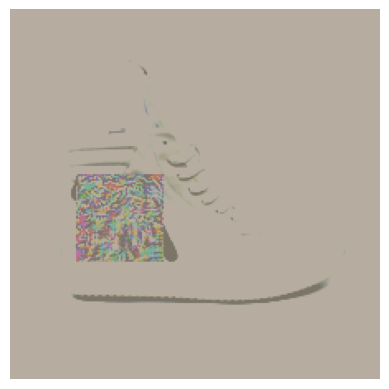

In [39]:
def apply_fgsm_attack(model, image, target_label, epsilon=0.03):
    new_image1 = image.clone().detach().requires_grad_(True)

    # Forward pass
    output = model(new_image1)
    loss = F.cross_entropy(output, target_label)

    model.zero_grad()

    # Backward pass
    loss.backward()

    # Collect the gradients of the input image
    data_grad = new_image1.grad.data

    # FGSM attack
    perturbed_image = fgsm_attack(new_image1, epsilon, data_grad)

    return perturbed_image

# Apply
perturbed_image = apply_fgsm_attack(model, patched_image, target_label)

show_image(perturbed_image)


Save the perturbed image

In [40]:
# Save and load
torch.save(final_patch, "perturbed_image.pt")

final_patch = torch.load("perturbed_image.pt",weights_only=False)

# Convert
perturbed_image_np = perturbed_image.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
perturbed_image_np = np.clip(perturbed_image_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)
perturbed_image_pil = Image.fromarray((perturbed_image_np * 255).astype(np.uint8))

# Ensure the directory exists
os.makedirs('Assignment2_OutputImage', exist_ok=True)

# Save the image in the 'Assignment2_Output' directory
perturbed_image_pil.save('Assignment2_OutputImage/final_perturbed_image.jpg')
print("Save successfully.")

Save successfully.


# Reference
[1] Duke AI XAI. "Adversarial Attacks Example Notebook." GitHub Repository. Available at: https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/adversarial-ai-example-notebooks/adversarial_attacks.ipynb

[2] TensorFlow. "Adversarial Attacks with the Fast Gradient Sign Method (FGSM)." TensorFlow Tutorials. Available at: https://www.tensorflow.org/tutorials/generative/adversarial_fgsm

